In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines']

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import dscnn
from normalizing_flows.models.variational import parameterize, nll_loss
from datasource import EraiRasDataLoader
from utils.pipeline_v2 import Pipeline, fillnan, clip, remove_monthly_means
from utils.distributions import normal

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
# regions
def southeast_us(dataset, scale_factor=1):
    lats, lons = dataset.lat, dataset.lon
    seus_lat_st = np.abs(lats - 25).argmin().values
    seus_lat_en = seus_lat_st + 15*scale_factor
    seus_lon_st = np.abs(lons - 260).argmin().values
    seus_lon_en = seus_lon_st + 30*scale_factor
    dataset_seus = dataset.isel(lat=slice(seus_lat_st, seus_lat_en),
                                lon=slice(seus_lon_st, seus_lon_en))
    return dataset_seus

erai_deg1_seus = southeast_us(erai_deg1)
ras_deg1_seus = southeast_us(ras_deg1)
ras_deg12_seus = southeast_us(ras_deg12, scale_factor=2)
ras_deg14_seus = southeast_us(ras_deg14, scale_factor=4)
ras_deg18_seus = southeast_us(ras_deg18, scale_factor=8)

In [4]:
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)
preprocess_maxt = Pipeline('MAXT', fillnan(0), clip(0), remove_monthly_means())
preprocess_hgt = Pipeline('HGT', fillnan(0), clip(0))
ras_seus_maxt_12 = preprocess_maxt(ras_deg12_seus)
ras_seus_maxt_1 = preprocess_maxt(ras_deg1_seus)
folds = list(split_fn(ras_seus_maxt_1, ras_seus_maxt_12))

In [5]:
def preprocess_vds(data_lo, data_hi, scale=2, k=6, stride=3, n_epochs=1, batch_size=100):
    data = tf.data.Dataset.zip((data_lo, data_hi))
    #data = data_util.extract_patches(data, k=k, stride=stride, scale=[1,scale])
    batch = data.batch(batch_size)
    return batch.repeat(n_epochs)

Fold 1/3
1200 training samples, 1200 test samples, 15x30
Train for 120 steps, validate for 120 steps
Epoch 1/10
120/120 [==============================] - 14s 114ms/step - loss: 3.1016 - val_loss: 2.1097
Epoch 2/10
120/120 [==============================] - 9s 73ms/step - loss: 1.9846 - val_loss: 1.9313
Epoch 3/10
120/120 [==============================] - 9s 75ms/step - loss: 1.8075 - val_loss: 1.7731
Epoch 4/10
120/120 [==============================] - 9s 74ms/step - loss: 1.6421 - val_loss: 1.6360
Epoch 5/10
120/120 [==============================] - 9s 73ms/step - loss: 1.4874 - val_loss: 1.5232
Epoch 6/10
120/120 [==============================] - 9s 76ms/step - loss: 1.3526 - val_loss: 1.4401
Epoch 7/10
120/120 [==============================] - 9s 77ms/step - loss: 1.2428 - val_loss: 1.3784
Epoch 8/10
120/120 [==============================] - 9s 76ms/step - loss: 1.1476 - val_loss: 1.3282
Epoch 9/10
120/120 [==============================] - 9s 72ms/step - loss: 1.0609 - val_l

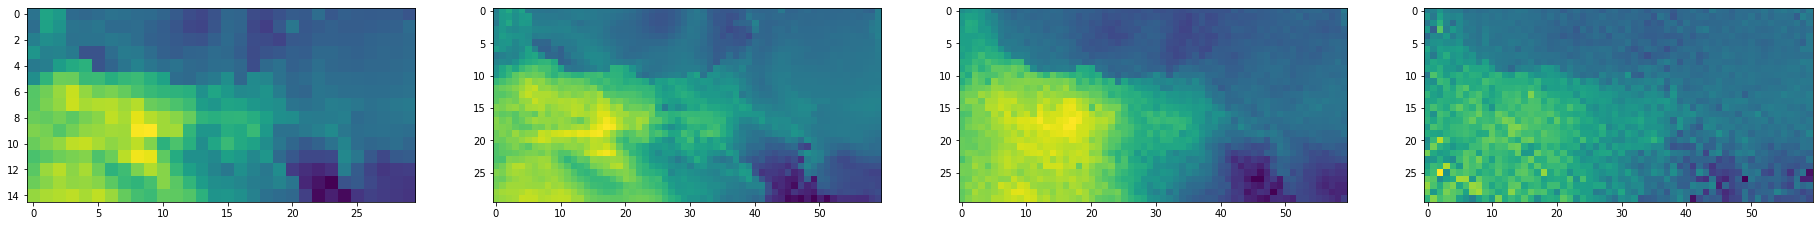

Fold 2/3
2400 training samples, 2400 test samples, 15x30
Train for 240 steps, validate for 240 steps
Epoch 1/10
240/240 [==============================] - 19s 79ms/step - loss: 2.3029 - val_loss: 1.7947
Epoch 2/10
240/240 [==============================] - 18s 77ms/step - loss: 1.6068 - val_loss: 1.5082
Epoch 3/10
240/240 [==============================] - 18s 74ms/step - loss: 1.3749 - val_loss: 1.3482
Epoch 4/10
240/240 [==============================] - 18s 75ms/step - loss: 1.2218 - val_loss: 1.2275
Epoch 5/10
240/240 [==============================] - 17s 72ms/step - loss: 1.1015 - val_loss: 1.1291
Epoch 6/10
240/240 [==============================] - 18s 74ms/step - loss: 0.9935 - val_loss: 1.0585
Epoch 7/10
240/240 [==============================] - 19s 77ms/step - loss: 0.9097 - val_loss: 0.9981
Epoch 8/10
240/240 [==============================] - 17s 73ms/step - loss: 0.8024 - val_loss: 0.9304
Epoch 9/10
240/240 [==============================] - 20s 84ms/step - loss: 0.7099 

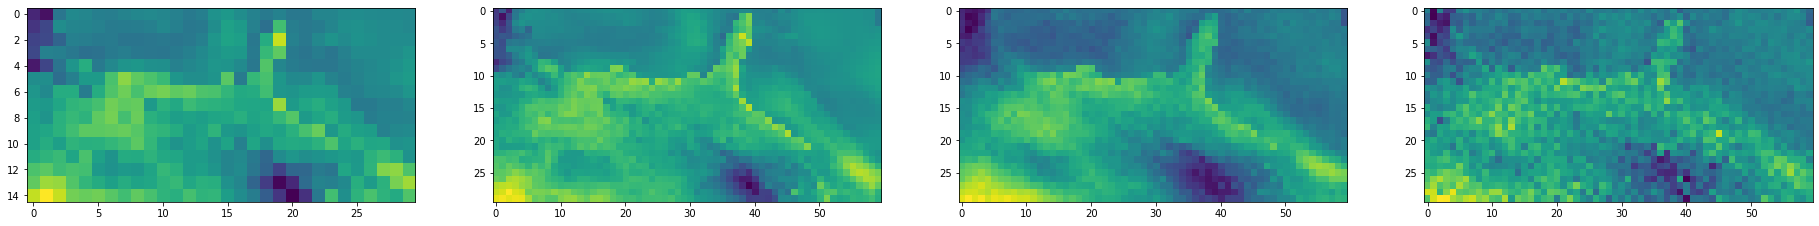

Fold 3/3
3600 training samples, 3600 test samples, 15x30
Train for 360 steps, validate for 360 steps
Epoch 1/10
360/360 [==============================] - 32s 88ms/step - loss: 2.0400 - val_loss: 1.5660
Epoch 2/10
360/360 [==============================] - 31s 86ms/step - loss: 1.3740 - val_loss: 1.2390
Epoch 3/10
360/360 [==============================] - 31s 85ms/step - loss: 1.1047 - val_loss: 1.0411
Epoch 4/10
360/360 [==============================] - 31s 85ms/step - loss: 0.9072 - val_loss: 0.9345
Epoch 5/10
360/360 [==============================] - 31s 86ms/step - loss: 0.7545 - val_loss: 0.8376
Epoch 6/10
360/360 [==============================] - 31s 87ms/step - loss: 0.6525 - val_loss: 0.8049
Epoch 7/10
360/360 [==============================] - 31s 87ms/step - loss: 0.5698 - val_loss: 0.7738
Epoch 8/10
360/360 [==============================] - 32s 90ms/step - loss: 0.5014 - val_loss: 0.7495
Epoch 9/10
360/360 [==============================] - 31s 87ms/step - loss: 0.4627 

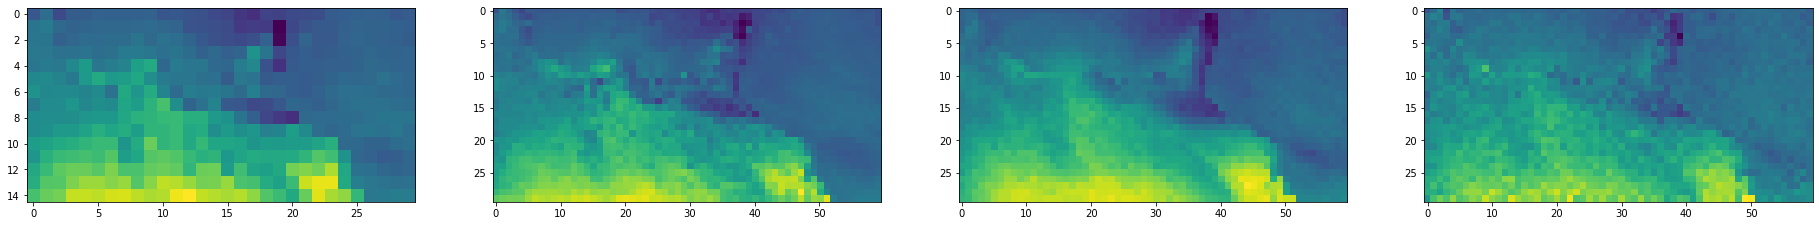

In [6]:
from tensorflow.keras.optimizers import Adamax
k, stride = 16, 4
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 10
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    wt, ht = train_lo.shape[1], train_lo.shape[2]
    print('{} training samples, {} test samples, {}x{}'.format(N_train, N_test, wt, ht))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, k=k, stride=stride, n_epochs=n_epochs, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, k=k, stride=stride, n_epochs=n_epochs, batch_size=sample_batch_size)
    #vdsrcnn = dscnn.create_vdsrcnn(scale=2, c_in=1, c_out=2, output_init='zeros')
    vdsrcnn = dscnn.create_bmg_cnn10(wt, ht, c_out=2)
    vdsrcnn = parameterize(vdsrcnn, normal)
    vdsrcnn.compile(loss=nll_loss(normal), optimizer=Adamax(lr=1.0E-3))
    vdsrcnn.fit(train_ds, epochs=n_epochs, steps_per_epoch=train_steps,
                validation_data=test_ds, validation_steps=test_steps)
    pred = vdsrcnn.predict_mean(test_lo_ds.batch(1))
    sample = vdsrcnn.sample(test_lo_ds.batch(1))
    plt.figure(figsize=(4*8,6))
    plt.subplot(1,4,1)
    plt.imshow(next(test_ds.__iter__())[0].numpy()[0].squeeze())
    plt.subplot(1,4,2)
    plt.imshow(next(test_ds.__iter__())[1].numpy()[0].squeeze())
    plt.subplot(1,4,3)
    plt.imshow(pred[0].numpy().squeeze())
    plt.subplot(1,4,4)
    plt.imshow(sample[0].numpy().squeeze())
    plt.show()